In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import gammaln_nr
from scipy.stats import poisson,nbinom,norm

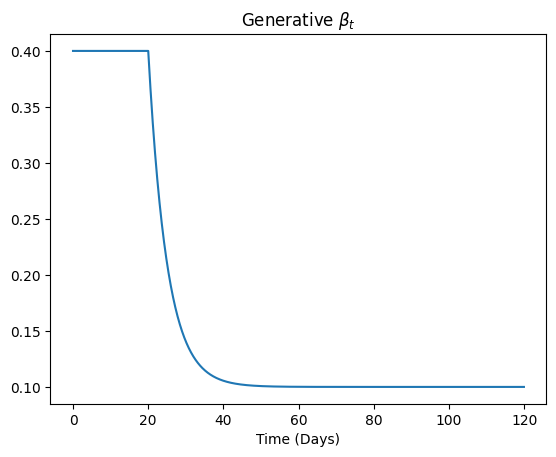

In [2]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(0)

gamma = 1/14
eta = 1/7
q = 0.1
mu = 0.004
rho = 0.1

T = 120
dt = 0.1
t_vec = np.arange(0,T,dt)

N = 100_000
I = 5
E = 5


beta_par = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_par,t) for t in t_vec])

state = np.zeros((5,len(t_vec)))
state[:,0] = np.array([N - I - E,E, I, 0,0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):

    new_E = (betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt
    new_I = (eta * state[1,time_index - 1]) * dt
    new_ER = (gamma * state[1,time_index -1]) * dt
    new_IR = (gamma * state[2,time_index - 1]) * dt
    new_D = (mu * state[2,time_index - 1]) * dt


    state[0,time_index] = state[0,time_index - 1] - new_E #S 
    state[1,time_index] = state[1,time_index - 1] + new_E - new_I - new_ER
    state[2,time_index] = state[2,time_index-1] + new_I - new_IR - new_D
    state[3,time_index] = state[3,time_index - 1] + new_ER + new_IR #R
    state[4,time_index] = new_I

    

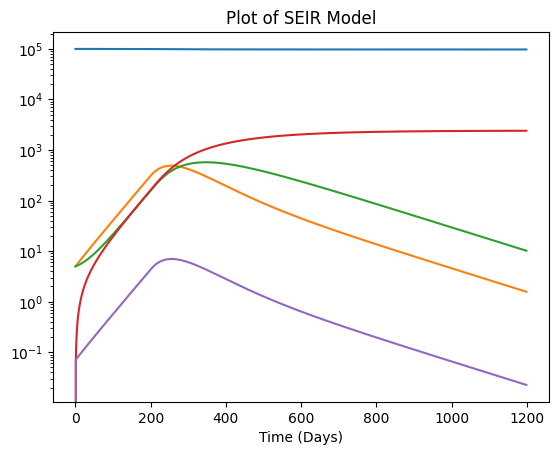

In [3]:
plt.yscale('log')
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(state.T[:])

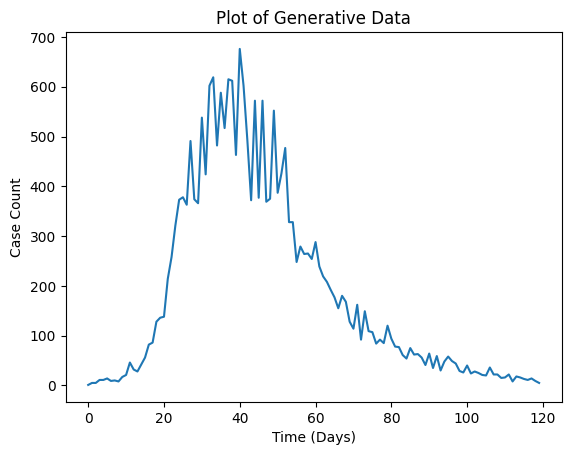

In [4]:
r = 50

data = np.expand_dims(rng.negative_binomial(n = r,p = r/(r + state[2,::int(1/dt)] + 0.005)),0)

#data = np.expand_dims(state[2,::int(1/dt)],0)

plt.title('Plot of Generative Data')
plt.xlabel('Time (Days)')
plt.ylabel('Case Count')
plt.plot(t_vec[::int(1/dt)],data.T)

In [5]:
def SEIR_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,eta,_ = model_params

    '''OU Process'''
    sig = 1.0
    mu = -2.0
    lam = 1/100

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_E = rng.poisson((particles[index,4,t] * (particles[index, 1, t] + 0.1 * particles[index, 2, t]) * particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_I = rng.poisson((eta * particles[index,1,t]) * dt)
        new_ER = rng.poisson((gamma * particles[index,1,t]) * dt)
        new_IR = rng.poisson((gamma * particles[index,2,t]) * dt)
        new_D = rng.poisson((0.004 * particles[index,2,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_E) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_E - new_I - new_ER) #E
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_I - new_IR - new_D) #I
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_ER + new_IR)
        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SEIR_Obs(data_point, particle_observations, model_params):
    #return norm.logpdf(data_point,loc = particle_observations[:,0],scale = np.sqrt(var))
    r = 1/model_params[2]
    weights = nbinom.logpmf(k = data_point,p = r/(r + particle_observations[:,0]),n = r)
    weights[np.isinf(weights)] = -10_000
    return weights


In [6]:

#(0.06547914,0.28245005)
#(1/14 = 0.07,1/7 = 0.14)

def SEIR_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    E_I_init = rng.integers(1,5,size = (num_particles * 2)).reshape((num_particles,2))
    particles_0[:,0] -= np.sum(E_I_init,axis = 1)
    particles_0[:,1] = E_I_init[:,0]
    particles_0[:,2] = E_I_init[:,1]
    particles_0[:,4] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':1000, 
                      'dt':0.1,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,eta,1/50),
        pf_params = pf_params,
        rng = rng,
        req_jit=False
        )

print(perf_counter() - t)


22.0679237239965


 Log Likelihood : -10532.963884408031
Root Mean Squared Error for the Data 192.13417431682993


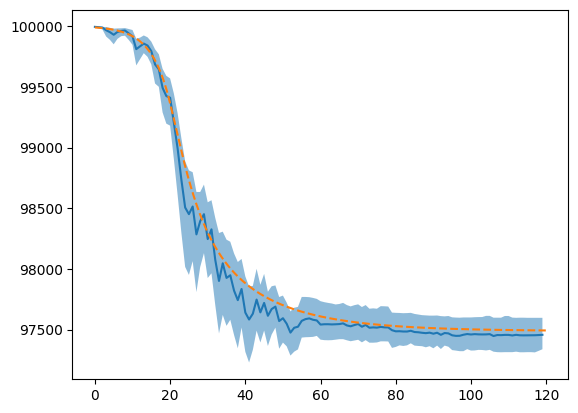

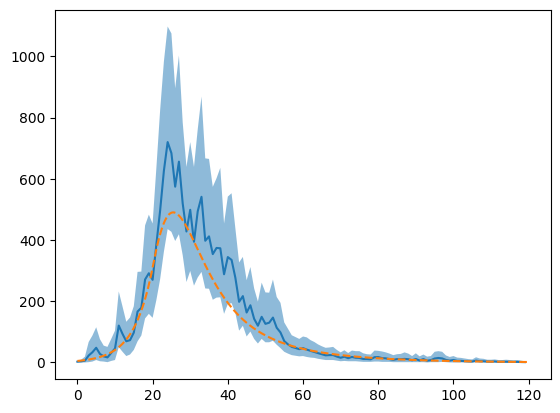

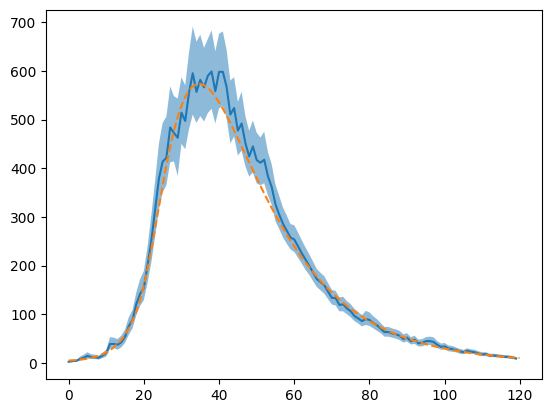

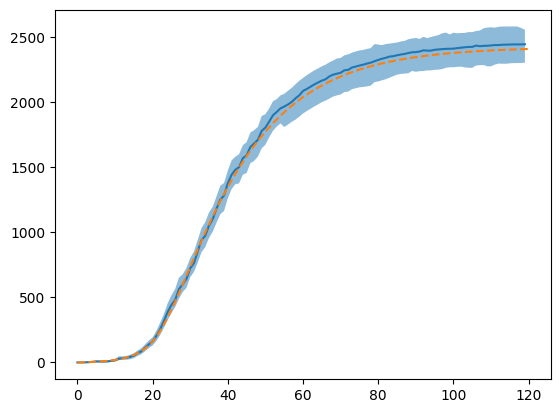

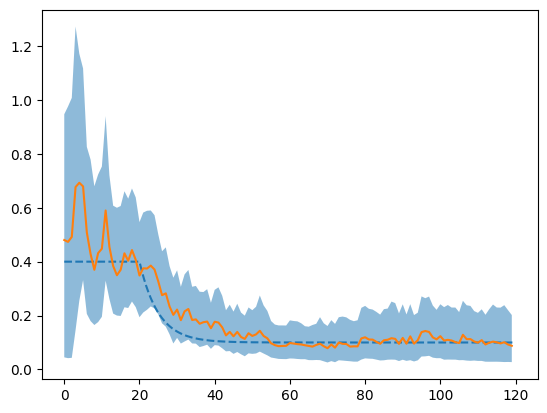

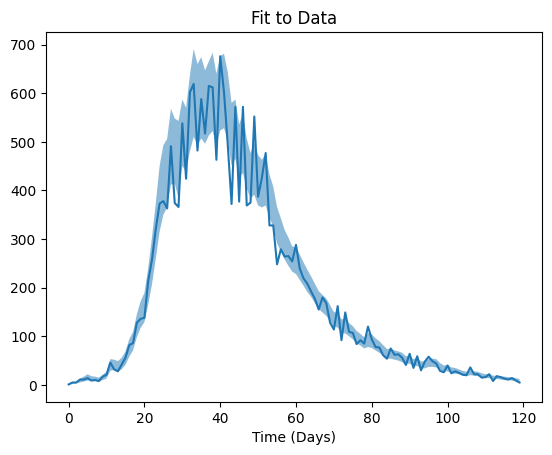

In [7]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

for i in range(4):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0))
    plt.plot(t_vec,state[i,:].T,'--')
    plt.show()

plt.plot(t_vec,betas,'--')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(output['particle_distribution'][:,4,:],weights = np.exp(output['log_weights']),axis = 0))
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


In [8]:
pmcmc_rng = np.random.default_rng(0)

num_particles = 1000

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

def seir_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 1/28.,max_val= 1/7) + uniform_numba_logpdf(theta[1],min_val = 1/15.,max_val = 1/3) + uniform_numba_logpdf(theta[2],min_val = 0.,max_val = 1.)

pmcmc_params = {'iterations':5_000,
                'init_params':np.array([0.1,0.1,0.01]),
                'prior':seir_prior,
                'init_cov':0.005 * np.eye(3),
                'burn_in':100}

pf_params = {'num_particles':1_000, 
                      'dt':1.,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init
                      }

t = perf_counter()
pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = rng,
                  req_jit=False
                  )
print(perf_counter() - t)




iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -10539.167985048645| Proposal [0.13204929 0.0968196  0.0386691 ]
iteration: 20| Acceptance rate: 0.05| Log-Likelihood: -10539.167985048645| Proposal [0.13204929 0.0968196  0.0386691 ]
iteration: 30| Acceptance rate: 0.03333333333333333| Log-Likelihood: -10539.167985048645| Proposal [0.13204929 0.0968196  0.0386691 ]
iteration: 40| Acceptance rate: 0.05| Log-Likelihood: -10535.166862031514| Proposal [0.10796261 0.19396472 0.01326827]
iteration: 50| Acceptance rate: 0.06| Log-Likelihood: -10528.86355739933| Proposal [0.0718178  0.18661148 0.01548039]
iteration: 60| Acceptance rate: 0.05| Log-Likelihood: -10528.86355739933| Proposal [0.0718178  0.18661148 0.01548039]
iteration: 70| Acceptance rate: 0.04285714285714286| Log-Likelihood: -10528.86355739933| Proposal [0.0718178  0.18661148 0.01548039]
iteration: 80| Acceptance rate: 0.0375| Log-Likelihood: -10528.86355739933| Proposal [0.0718178  0.18661148 0.01548039]
iteration: 90| Accept

-10525.24840889768
The Maximum Likelihood Estimate is [0.05638749 0.24530407 0.02143159] w/ LL of -10525.24840889768


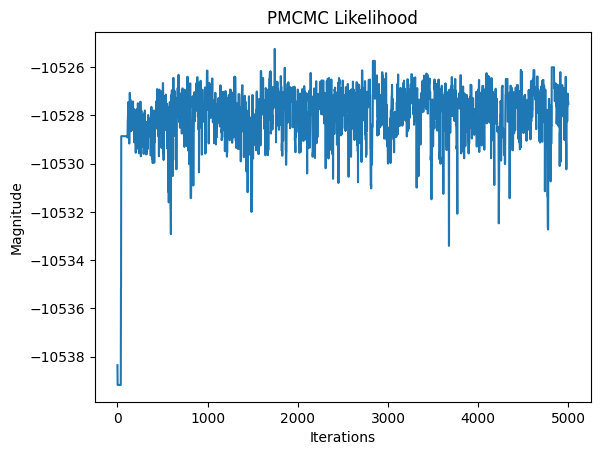

In [15]:
burn_in = 0

MLE = np.argmax(pmcmc_output['Log Likelihood'])

print(pmcmc_output['Log Likelihood'][MLE])

print(f"The Maximum Likelihood Estimate is {pmcmc_output['accepted_params'][:,MLE]} w/ LL of {pmcmc_output['Log Likelihood'][MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(pmcmc_output['Log Likelihood'])

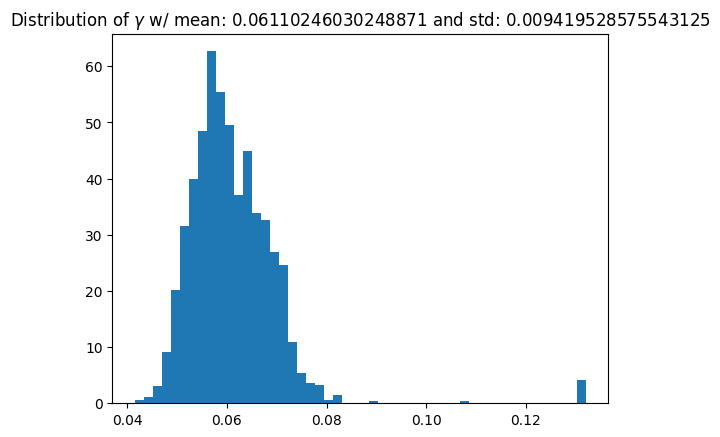

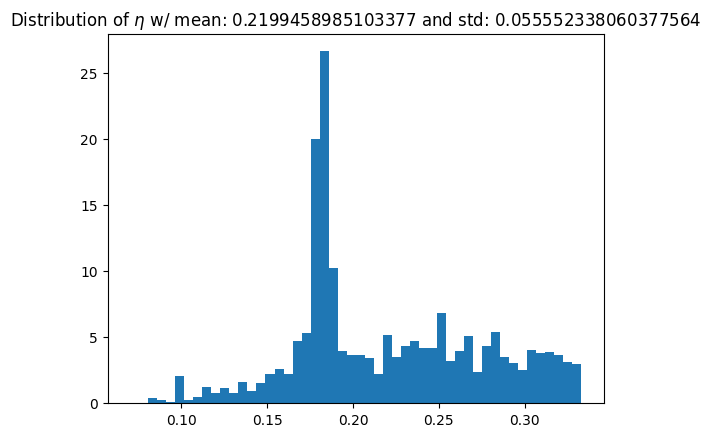

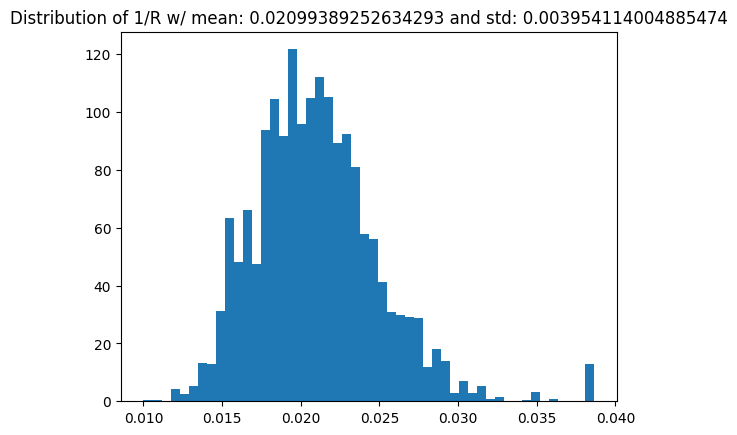

In [22]:
plt.title(f"Distribution of $\\gamma$ w/ mean: {np.mean(pmcmc_output['accepted_params'][0,burn_in:])} and std: {np.std(pmcmc_output['accepted_params'][0,burn_in:])}")
plt.hist(pmcmc_output['accepted_params'][0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\eta$ w/ mean: {np.mean((pmcmc_output['accepted_params'][1,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][1,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of 1/R w/ mean: {np.mean((pmcmc_output['accepted_params'][2,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][2,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][2,burn_in:]),density=True,bins = 50)
plt.show()

# plt.title(f"Distribution of OU Param $\\mu$ w/ mean: {np.mean(theta[2,burn_in:])} and std: {np.std(theta[2,burn_in:])}")
# plt.hist(theta[2,burn_in:],density=True,bins = 50)
# plt.show()

# plt.title(f"Distribution of OU Param $\\mu$ w/ mean: {np.mean(theta[3,burn_in:])} and std: {np.std(theta[3,burn_in:])}")
# plt.hist(theta[3,burn_in:],density=True,bins = 50)
# plt.show()




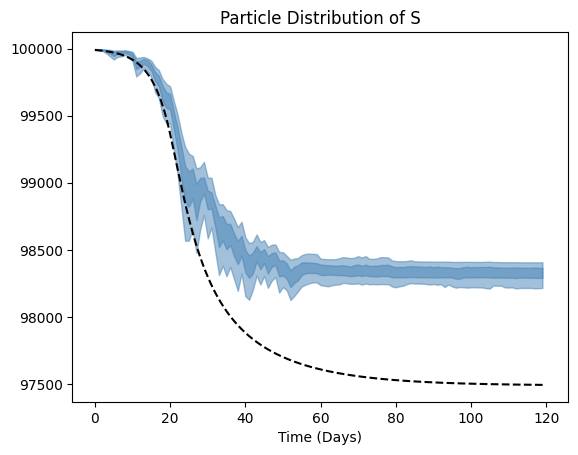

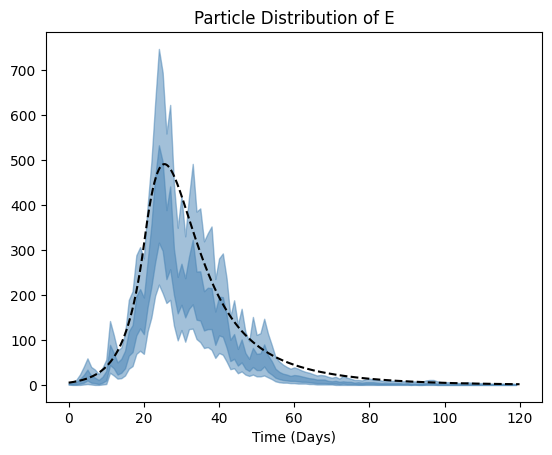

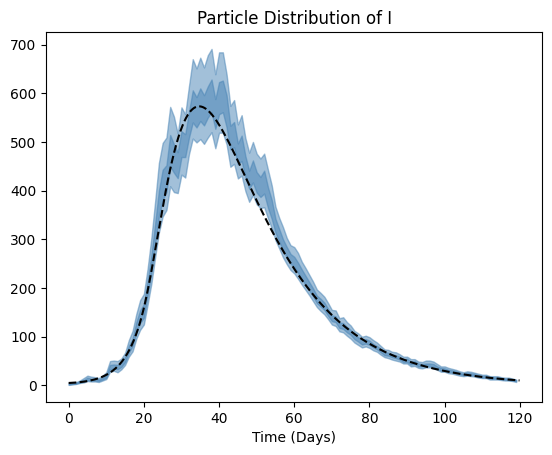

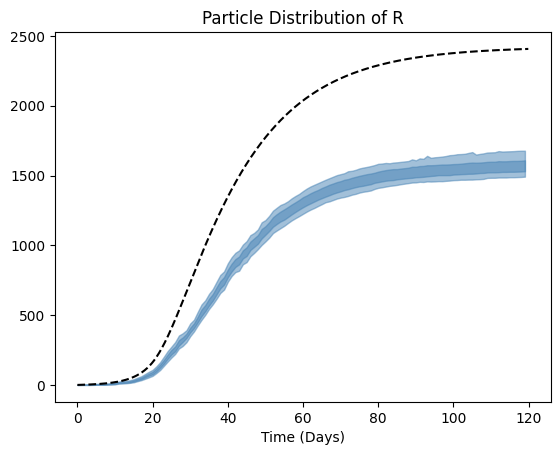

In [17]:
Labels = ['S','E','I','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.xlabel('Time (Days)')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    #plt.plot(t_vec[::int(1/dt)],[i,:,MLE])
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,5,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,25,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.show()

Root Mean Squared Error for the Data 192.12870625405156
Root Mean Squared Error for beta 0.12141442340306688


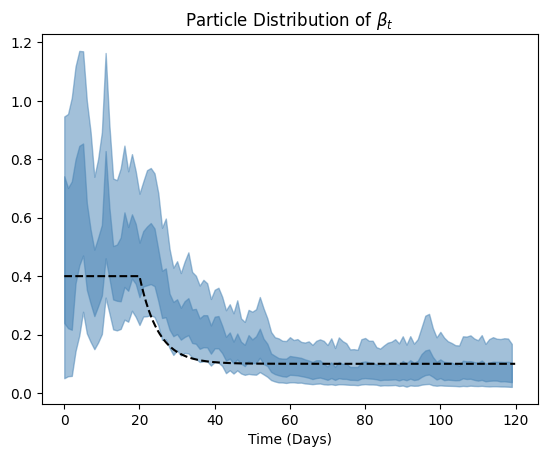

In [18]:
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(pmcmc_output['MLE_particle_observations'][:,0,:]))**2))}")
print(f"Root Mean Squared Error for beta {np.sqrt(np.mean((betas - np.mean(pmcmc_output['MLE_particle_dist'][:,4,:]))**2))}")
plt.title("Particle Distribution of $\\beta_t$")
plt.xlabel("Time (Days)")
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,5,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,25,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.show()

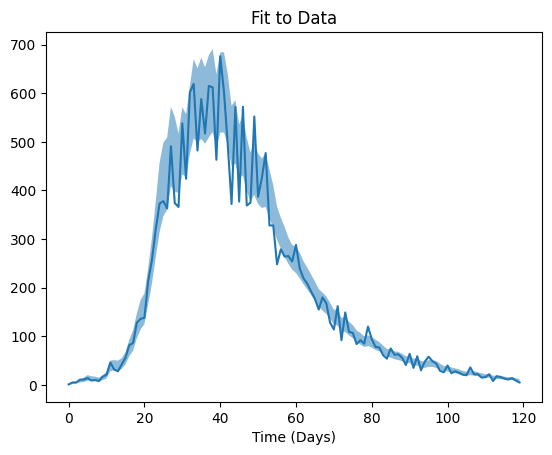

In [19]:
plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_observations'][:,0,:].T,5,axis = 1),np.percentile(pmcmc_output['MLE_particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


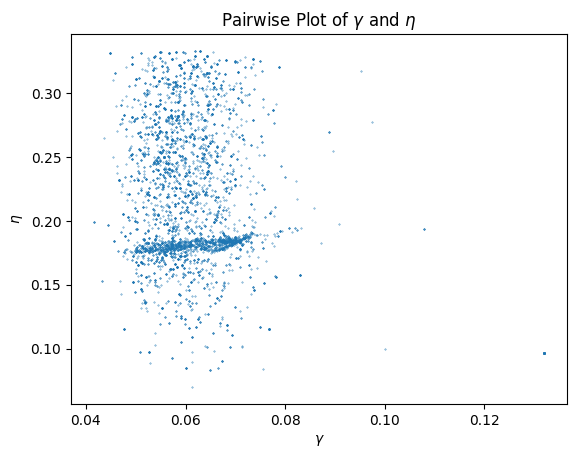

In [20]:
'''Pair plots'''

plt.title('Pairwise Plot of $\\gamma$ and $\\eta$')
plt.xlabel('$\\gamma$')
plt.ylabel('$\\eta$')
plt.scatter(pmcmc_output['accepted_params'][0,burn_in:],pmcmc_output['accepted_params'][1,burn_in:],s=0.1)

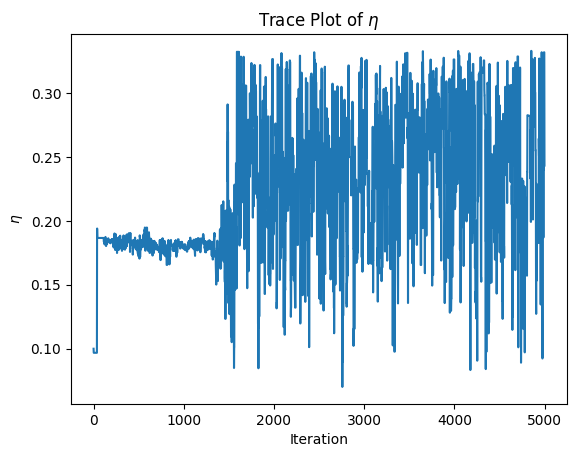

In [23]:
'''Pair plots'''

plt.title('Trace Plot of $\\eta$')
plt.xlabel('Iteration')
plt.ylabel('$\\eta$')
plt.plot(pmcmc_output['accepted_params'][1,burn_in:])